# Практическая работа №6
## Тема: Кластеризация
Выполнила Фонград Анастасия КИ21-16/1б

In [34]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

warnings.filterwarnings('ignore')

Возьмём данные о покупателях одного из магазинов

In [35]:
data = pd.read_csv("../data/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Предварительная обработка данных

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Удалим ID и строки, в которых не указан income

In [37]:
data.dropna(inplace=True)
data.drop("ID", axis=1, inplace=True)
data.drop("Dt_Customer", axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2216 non-null   int64  
 1   Education            2216 non-null   object 
 2   Marital_Status       2216 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2216 non-null   int64  
 5   Teenhome             2216 non-null   int64  
 6   Recency              2216 non-null   int64  
 7   MntWines             2216 non-null   int64  
 8   MntFruits            2216 non-null   int64  
 9   MntMeatProducts      2216 non-null   int64  
 10  MntFishProducts      2216 non-null   int64  
 11  MntSweetProducts     2216 non-null   int64  
 12  MntGoldProds         2216 non-null   int64  
 13  NumDealsPurchases    2216 non-null   int64  
 14  NumWebPurchases      2216 non-null   int64  
 15  NumCatalogPurchases  2216 non-null   i

Разделим признаки на категориальные и числовые

In [38]:
numeric = []
categorical = []
for name in data.columns:
    if data[name].dtype != "object" and data[name].nunique() > 5:
        numeric.append(name)
    else:
        categorical.append(name)
columns = numeric + categorical
print("Numeric features:", numeric)
print("Categorical features:", categorical)

Numeric features: ['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
Categorical features: ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


Нормализуем числовые признаки

In [39]:
data[numeric] = MinMaxScaler().fit_transform(data[numeric])
data[numeric].describe()

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,0.736120,0.075973,0.495077,0.204348,0.132442,0.096809,0.145319,0.103164,0.136963,0.154904,0.151307,0.095394,0.446230,0.265952
std,0.116365,0.037858,0.292408,0.225940,0.199969,0.130019,0.211398,0.156764,0.161419,0.128248,0.101517,0.104526,0.250060,0.121268
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.640777,0.050491,0.242424,0.016075,0.010050,0.009275,0.011583,0.003817,0.028037,0.066667,0.074074,0.000000,0.230769,0.150000
50%,0.747573,0.074671,0.494949,0.116879,0.040201,0.039420,0.046332,0.030534,0.076324,0.133333,0.148148,0.071429,0.384615,0.300000
75%,0.815534,0.100449,0.747475,0.338245,0.165829,0.134638,0.193050,0.125954,0.174455,0.200000,0.222222,0.142857,0.615385,0.350000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Кодируем категориальные признаки

In [40]:
le = LabelEncoder()
for column in categorical:
    data[column] = le.fit_transform(data[column])
    data[column] = le.fit_transform(data[column])
    data[column] = data[column].astype("category")
    data[column] = data[column].astype("category")

Разобьём выборку на train и test

## Кластеризация исходных данных

       count          mean       std       min       25%       50%       75%  \
col1  2216.0 -2.436879e-16  1.129960 -1.890135 -0.689686  0.330986  0.450334   
col2  2216.0  6.893804e-17  1.077733 -3.159557 -1.178740 -0.154775  0.750234   
col3  2216.0 -4.969951e-17  0.626941 -1.508159 -0.491935 -0.120309  0.587908   

           max  
col1  2.562921  
col2  3.737115  
col3  1.639810  


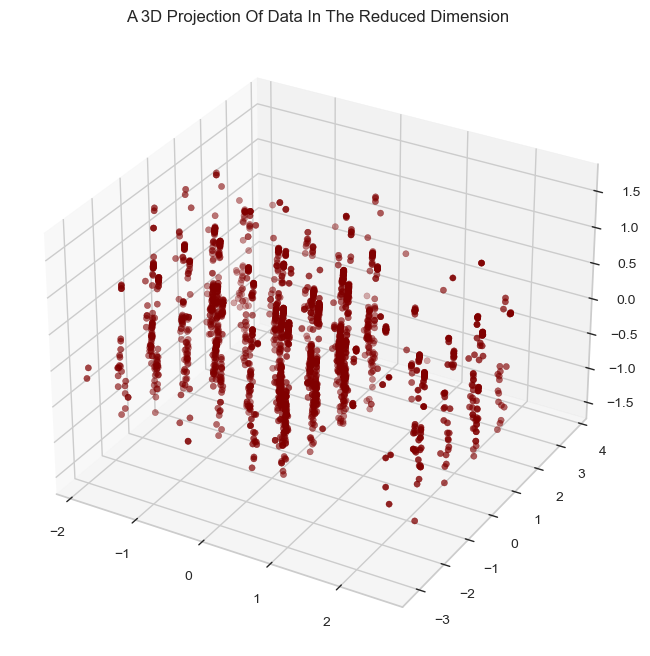

In [41]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(data)
PCA_ds = pd.DataFrame(pca.transform(data), columns=(["col1","col2", "col3"]))
print(PCA_ds.describe().T)

#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


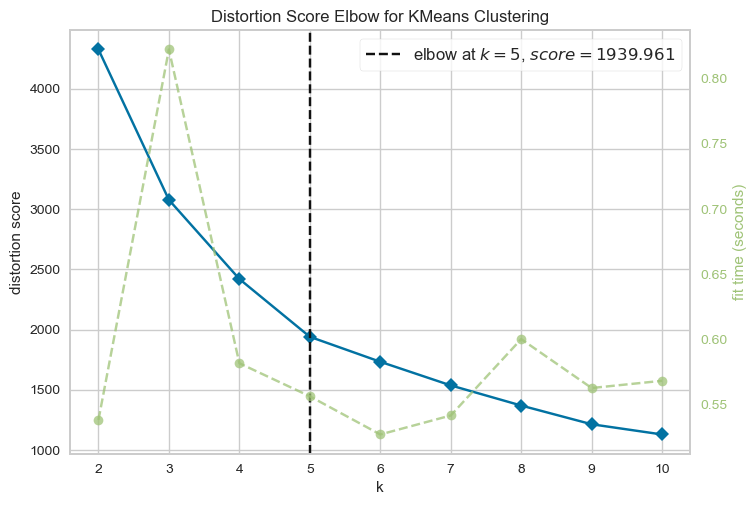

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [43]:
AC = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

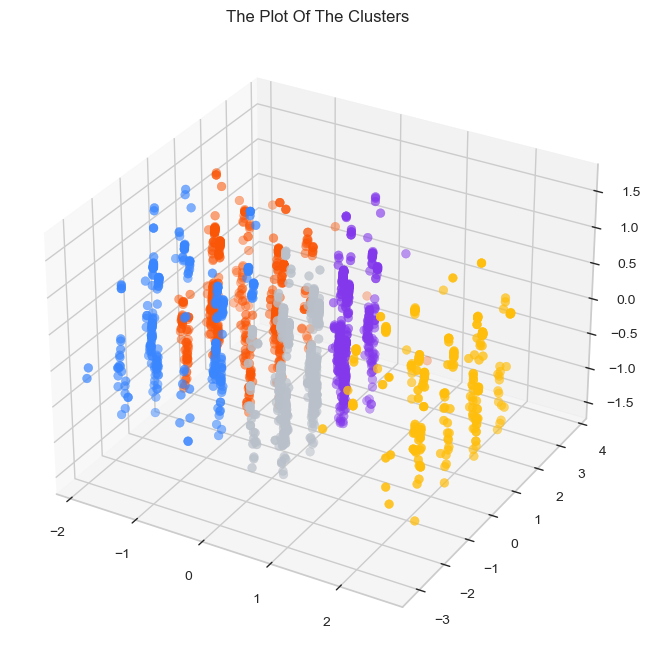

In [44]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
cmap = colors.ListedColormap(["#ffbe0b", "#fb5607", "#ff006e", "#B9C0C9", "#8338ec", "#3a86ff"])
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()